In [1]:
import pandas as pd
import numpy as np
import itertools as it
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

# Preliminaries, make variables for plotting and labels

In [2]:
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',
                   3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
month_abr = {'08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec','01':'Jan',
             '02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul'}

now = datetime.now()
today = now.strftime("%Y-%m-%d")
start = '2020-08-01'

alldates = pd.date_range(start=start, end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
date_dict = dict(zip(DATE_DF['date'].values,
                     list(range(len(DATE_DF['date'].values)))))
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()

dates_tt = ['2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
            '2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01']
dates_ll = ['Aug','Sep','Oct','Nov','Dec','2021','Feb','Mar','Apr','May']

In [3]:
col_vars = ['positive_tests','total_tests']
lab_vars = ['cases','tests']
lab_vars1 = ['positive tests','tests administered']

def plot_school(data_u, college_label, college_abbrv, college_color='.2',
                lw=2.5, wid=7, save=True):
    """
    Parameters
    ----------
    data_u (pd.DataFrame):
        dataframe of the university in question, from `ihe_df`
    
    college_label (str):
        full name of college, from ipeds_df

    college_abbr (str):
        colloquial / abbreviated name

    college_color (str):
        if you want to be fancy, google the college and add "hex" and copy/paste
        the "#XXXXXX" color code of the school's branding
    
    save (bool):
        whether or not to save the figure

    Returns
    -------
    if save==True, this function saves a png and pdf of the plotted data
    """ 

    num_students = ipeds_df.loc[ipeds_df['name']==college_label
                                ,'enrollment_fulltime'].values[0]
    num_employee = ipeds_df.loc[ipeds_df['name']==college_label,
                                'employment_fulltime'].values[0]
    as_of_year = ipeds_df.loc[ipeds_df['name']==college_label,
                              'year'].values[0]
    pe1 = [path_effects.Stroke(linewidth=lw*1.75, foreground='w'),
           path_effects.Normal()]
    pe2 = [path_effects.Stroke(linewidth=1.5, foreground='w'),
           path_effects.Normal()]

    bin_widths = {}
    for i,col in enumerate(col_vars):
        reported_data = data_u.loc[(data_u[col]!=0)]['date'].index.values
        if reported_data.shape[0]>0:
            days_between_reporting = np.diff(reported_data)
            bin_widths[col] = np.min(days_between_reporting)+0.1
        else:
            bin_widths[col] = 0.0
#         bin_widths[col] = np.mean(days_between_reporting)


    fig, ax = plt.subplots(1,2,figsize=(12.5,5.0),dpi=100)
    plt.subplots_adjust(wspace=0.2)

    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])

    for li,l in enumerate(col_vars):
        yvals_u = data_u[l].values
        if sum(yvals_u)>0:
            yvalr_u = data_u[l].rolling(window=wid).mean().values
            yvalr_u[:wid-1] = np.mean(yvals_u[:wid-1])
            totsum = int(sum(data_u[l].values))
            roll_avg = data_u[l].rolling(window=int(wid*2)).mean()
            pct_diffs = np.nan_to_num(roll_avg.pct_change().values)
            pct_diffs[pct_diffs>0.3] = 0.3
            norm = matplotlib.colors.Normalize(vmin=-0.2, vmax=0.2)
            cvals = norm(pct_diffs)
            col = plt.cm.Greys(cvals)

            ax[li].bar(xvals_u, yvals_u, color='.8', width=bin_widths[l], lw=0)
            ax[li].bar(xvals_u, yvals_u, color=col, ec='.3', alpha=0.95,
                       width=bin_widths[l], lw=bin_widths[l]/5)
            ax[li].plot(xvals_u, yvalr_u, color=college_color, linewidth=lw,
                        alpha=0.9, path_effects=pe1,
                        label='%i-day rolling average\n(total %s: %s)'%(
                                wid, lab_vars[li],"{:,}".format(int(totsum))))

            if bin_widths[l] > 5:
                freq = 'weekly'
            if bin_widths[l] > 2 and bin_widths[l] <= 5:
                freq = 'twice weekly'
            if bin_widths[l] <= 2:
                freq = 'daily'
            ax[li].set_title("New %s (reported %s)"%(lab_vars1[li],freq),
                             x=0.0, ha='left', color='.4')

        else:
            totsum = 0.0
            ax[li].plot(xvals_u, [0]*len(xvals_u), color=college_color,
                        linewidth=lw, alpha=0.9, path_effects=pe1,
                        label='%i-day rolling average\n(total %s: %s)'%(
                                wid, lab_vars[li],"{:,}".format(int(totsum))))
            ax[li].set_title("No reported %s"%(lab_vars1[li]),
                             x=0.0, ha='left', color='.4')
            ax[li].set_ylim(0,1000)
            


    sd = "%s %i, %s"%(month_abr[data_u['date'].min()[5:7]],
                      int(data_u['date'].min()[8:]),
                      data_u['date'].min()[:4])
    ld = "%s %i, %s"%(month_abr[data_u['date'].max()[5:7]],
                      int(data_u['date'].max()[8:]),
                      data_u['date'].max()[:4])
    plt.suptitle('   %s COVID-19 Testing Data: %s — %s'%(college_label,sd,ld),
                 fontsize='x-large', color='.2', y=1.075)

    ax[0].text(1.05, 1.2, '(%s)'%data_u['url'].unique()[0],
               transform=ax[0].transAxes, ha='center', va='top',
               fontsize='medium',color='.3')
    ax[0].text(1.05, 1.155,
               'Approximate full-time population (%i): '%as_of_year+\
               'students: %s; employees: %s'%("{:,}".format(int(num_students)),
                                              "{:,}".format(int(num_employee))),
               transform=ax[0].transAxes, ha='center', va='top',
               fontsize='small',color='.5')

    for a in fig.axes:
        l = a.legend(fontsize='medium')
        for text in l.get_texts():
            text.set_color('.3')
            text.set_path_effects(pe2)

        l.set_zorder(20)
        a.set_xticks([date_dict[i] for i in dates_tt])
        a.set_xticklabels(dates_ll,fontsize=9.25)
        ytx = np.unique(np.round(a.get_yticks()))
        a.set_yticks(ytx)
        a.set_yticklabels(["{:,}".format(int(y)) for y in ytx])
        a.set_xlim(date_dict[data_u['date'].min()]-2,
                   date_dict[data_u['date'].max()]+2)
        a.grid(linewidth=0.5,color='.75',alpha=0.5)
        a.tick_params(labelcolor='.4',color='.7')

    if save:
        plt.savefig('../figs/pngs/example_%s.png'%college_abbrv.replace(' ',''),
                    dpi=425, bbox_inches='tight')
        plt.savefig('../figs/pdfs/example_%s.pdf'%college_abbrv.replace(' ',''),
                    bbox_inches='tight')

    plt.show()

# Look at a few example colleges:

In [4]:
ihe_df = pd.read_csv('../data/campus_covid_fall2020_full.csv', dtype={'ipeds_id':str, 'fips':str})
ipeds_df  = pd.read_csv('../data/campus_covid_ipeds.csv', dtype={'ipeds_id':str, 'fips':str})

In [5]:
data_date = '2020-08-01'

## Starting with Northeastern University

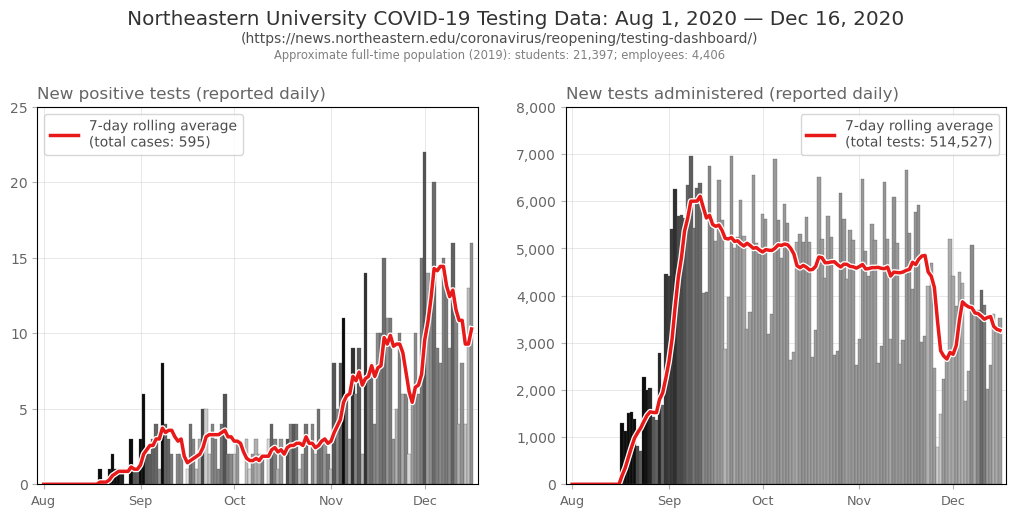

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Northeastern University,https://news.northeastern.edu/coronavirus/reop...,167358,29,Massachusetts,25025,595,514527
1,2020-08-02,0,0,Northeastern University,https://news.northeastern.edu/coronavirus/reop...,167358,29,Massachusetts,25025,595,514527
2,2020-08-03,0,0,Northeastern University,https://news.northeastern.edu/coronavirus/reop...,167358,30,Massachusetts,25025,595,514527
3,2020-08-04,0,0,Northeastern University,https://news.northeastern.edu/coronavirus/reop...,167358,30,Massachusetts,25025,595,514527
4,2020-08-05,0,0,Northeastern University,https://news.northeastern.edu/coronavirus/reop...,167358,30,Massachusetts,25025,595,514527


In [6]:
college_label = 'Northeastern University'
college_abbrv = 'Northeastern'
college_color = '#E50000'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

____________________

# Duke University

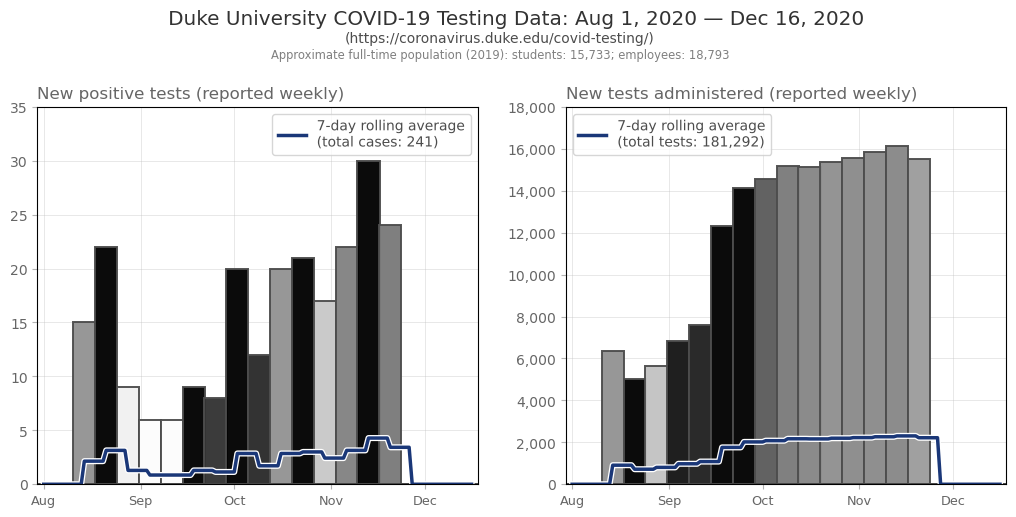

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Duke University,https://coronavirus.duke.edu/covid-testing/,198419,29,North Carolina,37063,241,181292
1,2020-08-02,0,0,Duke University,https://coronavirus.duke.edu/covid-testing/,198419,29,North Carolina,37063,241,181292
2,2020-08-03,0,0,Duke University,https://coronavirus.duke.edu/covid-testing/,198419,30,North Carolina,37063,241,181292
3,2020-08-04,0,0,Duke University,https://coronavirus.duke.edu/covid-testing/,198419,30,North Carolina,37063,241,181292
4,2020-08-05,0,0,Duke University,https://coronavirus.duke.edu/covid-testing/,198419,30,North Carolina,37063,241,181292


In [7]:
college_label = 'Duke University'
college_abbrv = 'Duke'
college_color = '#012169'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

__________

# University of Arizona

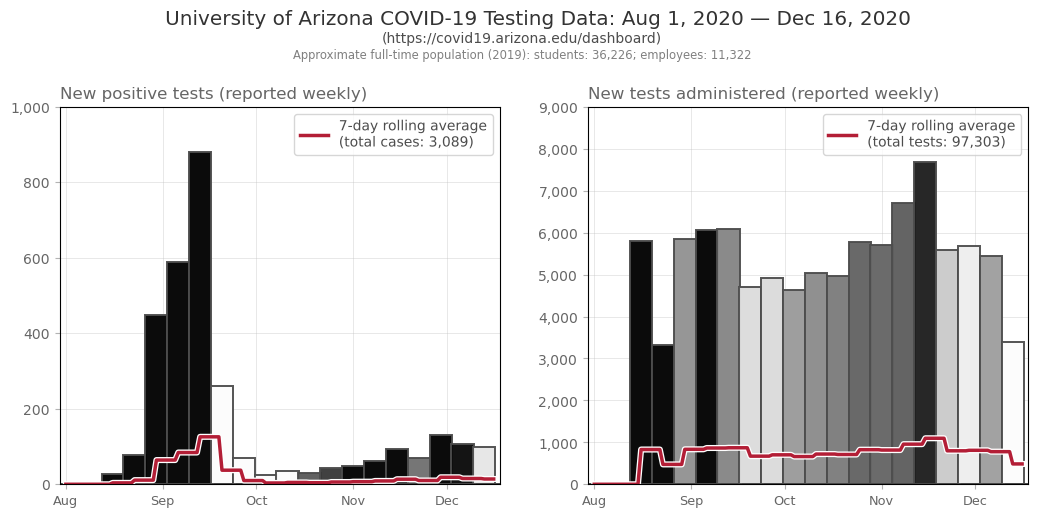

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of Arizona,https://covid19.arizona.edu/dashboard,104179,29,Arizona,04019,3089,97303
1,2020-08-02,0,0,University of Arizona,https://covid19.arizona.edu/dashboard,104179,29,Arizona,04019,3089,97303
2,2020-08-03,0,0,University of Arizona,https://covid19.arizona.edu/dashboard,104179,30,Arizona,04019,3089,97303
3,2020-08-04,0,0,University of Arizona,https://covid19.arizona.edu/dashboard,104179,30,Arizona,04019,3089,97303
4,2020-08-05,0,0,University of Arizona,https://covid19.arizona.edu/dashboard,104179,30,Arizona,04019,3089,97303


In [8]:
college_label = 'University of Arizona'
college_abbrv = 'U of A'
college_color = '#AB0520'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

____________

# University of Colorado Boulder

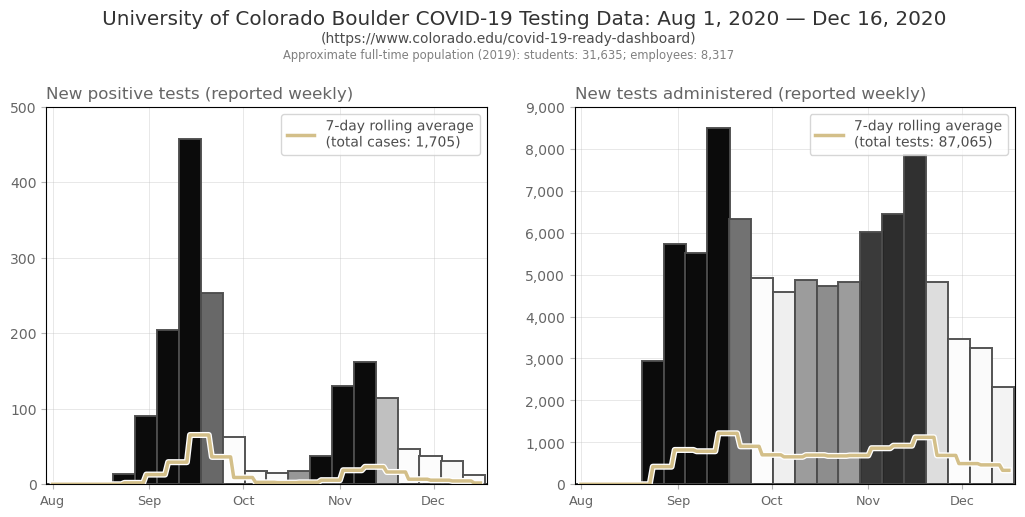

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of Colorado Boulder,https://www.colorado.edu/covid-19-ready-dashboard,126614,29,Colorado,08013,1705,87065
1,2020-08-02,0,0,University of Colorado Boulder,https://www.colorado.edu/covid-19-ready-dashboard,126614,29,Colorado,08013,1705,87065
2,2020-08-03,0,0,University of Colorado Boulder,https://www.colorado.edu/covid-19-ready-dashboard,126614,30,Colorado,08013,1705,87065
3,2020-08-04,0,0,University of Colorado Boulder,https://www.colorado.edu/covid-19-ready-dashboard,126614,30,Colorado,08013,1705,87065
4,2020-08-05,0,0,University of Colorado Boulder,https://www.colorado.edu/covid-19-ready-dashboard,126614,30,Colorado,08013,1705,87065


In [9]:
college_label = 'University of Colorado Boulder'
college_abbrv = 'CU Boulder'
college_color = '#CFB87C'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

___________

# The University of Tennessee-Knoxville

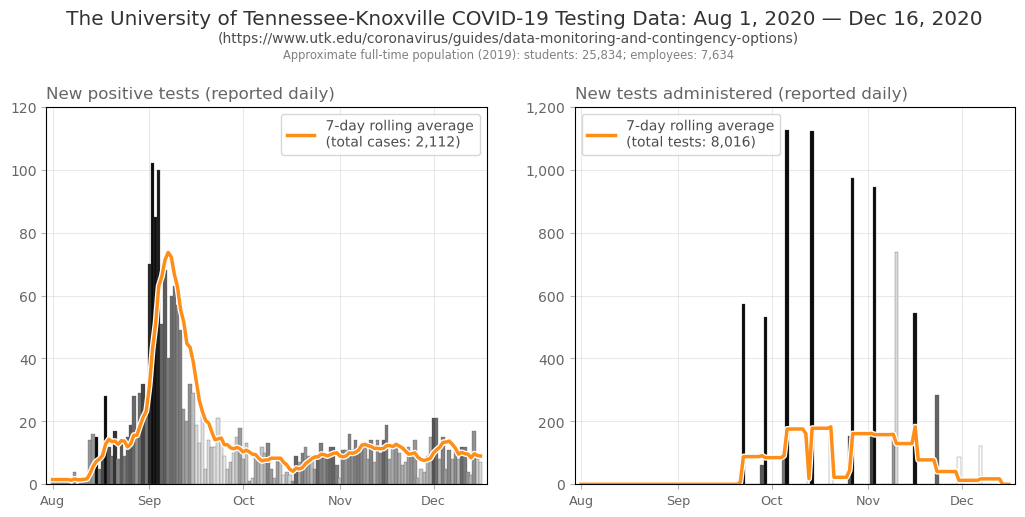

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,1,The University of Tennessee-Knoxville,https://www.utk.edu/coronavirus/guides/data-mo...,221759,29,Tennessee,47093,2112,8016
1,2020-08-02,0,2,The University of Tennessee-Knoxville,https://www.utk.edu/coronavirus/guides/data-mo...,221759,29,Tennessee,47093,2112,8016
2,2020-08-03,0,2,The University of Tennessee-Knoxville,https://www.utk.edu/coronavirus/guides/data-mo...,221759,30,Tennessee,47093,2112,8016
3,2020-08-04,0,1,The University of Tennessee-Knoxville,https://www.utk.edu/coronavirus/guides/data-mo...,221759,30,Tennessee,47093,2112,8016
4,2020-08-05,0,1,The University of Tennessee-Knoxville,https://www.utk.edu/coronavirus/guides/data-mo...,221759,30,Tennessee,47093,2112,8016


In [10]:
college_label = 'The University of Tennessee-Knoxville'
college_abbrv = 'UT Knoxville'
college_color = '#ff8200'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_________

# Baylor University

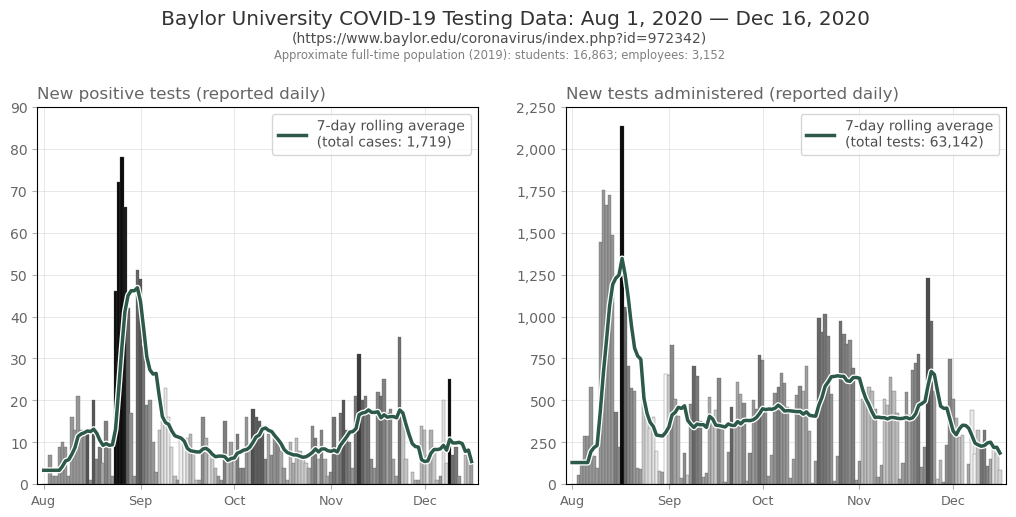

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Baylor University,https://www.baylor.edu/coronavirus/index.php?i...,223232,29,Texas,48309,1719,63142
1,2020-08-02,0,0,Baylor University,https://www.baylor.edu/coronavirus/index.php?i...,223232,29,Texas,48309,1719,63142
2,2020-08-03,58,7,Baylor University,https://www.baylor.edu/coronavirus/index.php?i...,223232,30,Texas,48309,1719,63142
3,2020-08-04,145,2,Baylor University,https://www.baylor.edu/coronavirus/index.php?i...,223232,30,Texas,48309,1719,63142
4,2020-08-05,286,2,Baylor University,https://www.baylor.edu/coronavirus/index.php?i...,223232,30,Texas,48309,1719,63142


In [11]:
college_label = 'Baylor University'
college_abbrv = 'Baylor'
college_color = '#154734'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

___________

# North Carolina State University at Raleigh

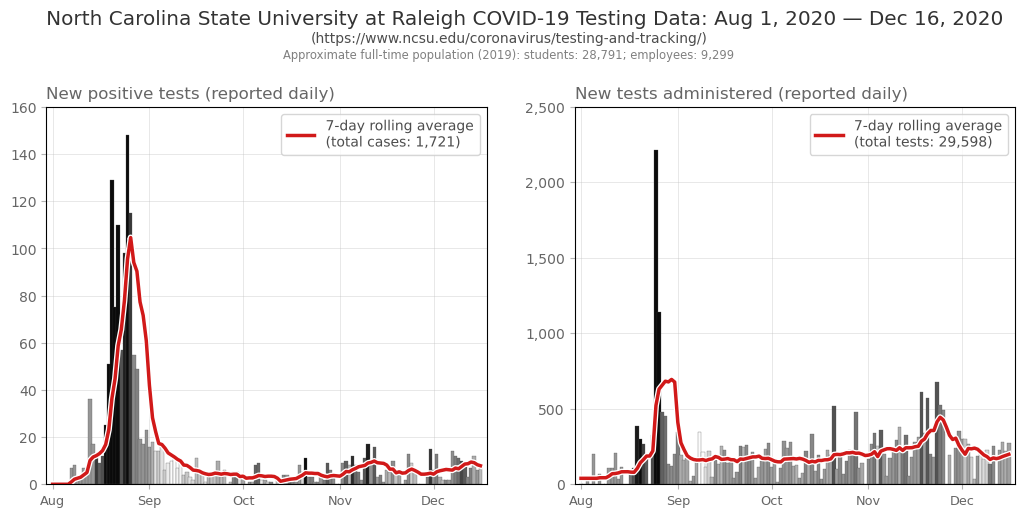

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,North Carolina State University at Raleigh,https://www.ncsu.edu/coronavirus/testing-and-t...,199193,29,North Carolina,37183,1721,29598
1,2020-08-02,0,0,North Carolina State University at Raleigh,https://www.ncsu.edu/coronavirus/testing-and-t...,199193,29,North Carolina,37183,1721,29598
2,2020-08-03,29,0,North Carolina State University at Raleigh,https://www.ncsu.edu/coronavirus/testing-and-t...,199193,30,North Carolina,37183,1721,29598
3,2020-08-04,3,0,North Carolina State University at Raleigh,https://www.ncsu.edu/coronavirus/testing-and-t...,199193,30,North Carolina,37183,1721,29598
4,2020-08-05,200,0,North Carolina State University at Raleigh,https://www.ncsu.edu/coronavirus/testing-and-t...,199193,30,North Carolina,37183,1721,29598


In [12]:
college_label = 'North Carolina State University at Raleigh'
college_abbrv = 'NC State'
college_color = '#CC0000'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_________________

# University of California-Los Angeles

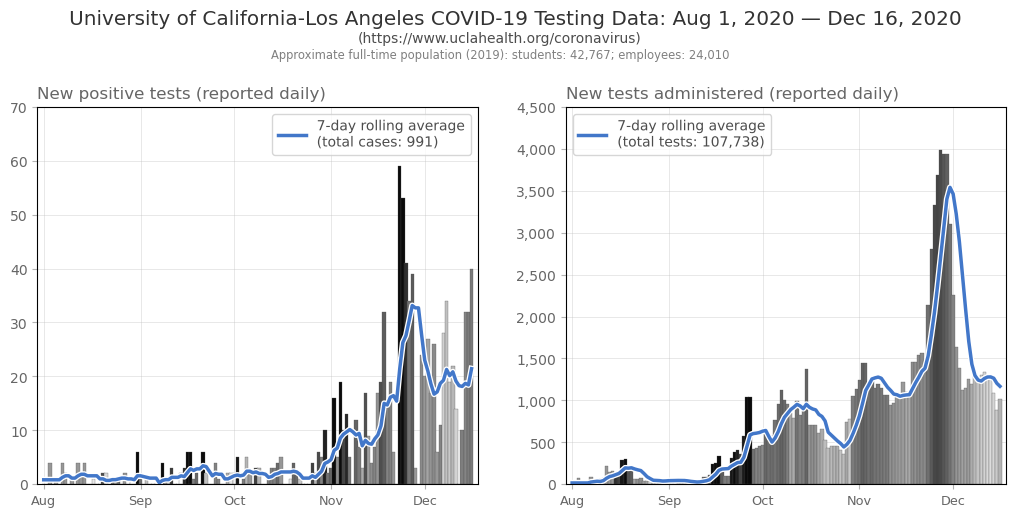

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of California-Los Angeles,https://www.uclahealth.org/coronavirus,110662,29,California,06037,991,107738
1,2020-08-02,0,0,University of California-Los Angeles,https://www.uclahealth.org/coronavirus,110662,29,California,06037,991,107738
2,2020-08-03,77,4,University of California-Los Angeles,https://www.uclahealth.org/coronavirus,110662,30,California,06037,991,107738
3,2020-08-04,0,0,University of California-Los Angeles,https://www.uclahealth.org/coronavirus,110662,30,California,06037,991,107738
4,2020-08-05,18,1,University of California-Los Angeles,https://www.uclahealth.org/coronavirus,110662,30,California,06037,991,107738


In [13]:
college_label = 'University of California-Los Angeles'
college_abbrv = 'UCLA'
college_color = '#2D68C4'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_____________

# Georgia Institute of Technology-Main Campus

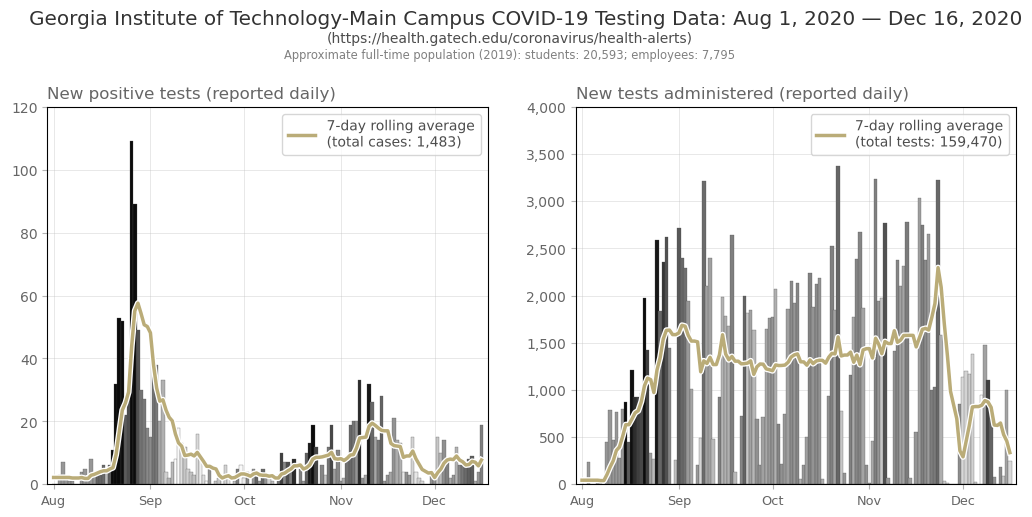

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Georgia Institute of Technology-Main Campus,https://health.gatech.edu/coronavirus/health-a...,139755,29,Georgia,13121,1483,159470
1,2020-08-02,0,0,Georgia Institute of Technology-Main Campus,https://health.gatech.edu/coronavirus/health-a...,139755,29,Georgia,13121,1483,159470
2,2020-08-03,231,3,Georgia Institute of Technology-Main Campus,https://health.gatech.edu/coronavirus/health-a...,139755,30,Georgia,13121,1483,159470
3,2020-08-04,7,7,Georgia Institute of Technology-Main Campus,https://health.gatech.edu/coronavirus/health-a...,139755,30,Georgia,13121,1483,159470
4,2020-08-05,8,2,Georgia Institute of Technology-Main Campus,https://health.gatech.edu/coronavirus/health-a...,139755,30,Georgia,13121,1483,159470


In [14]:
college_label = 'Georgia Institute of Technology-Main Campus'
college_abbrv = 'Georgia Tech'
college_color = '#B3A369'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

____________

# University of Kansas

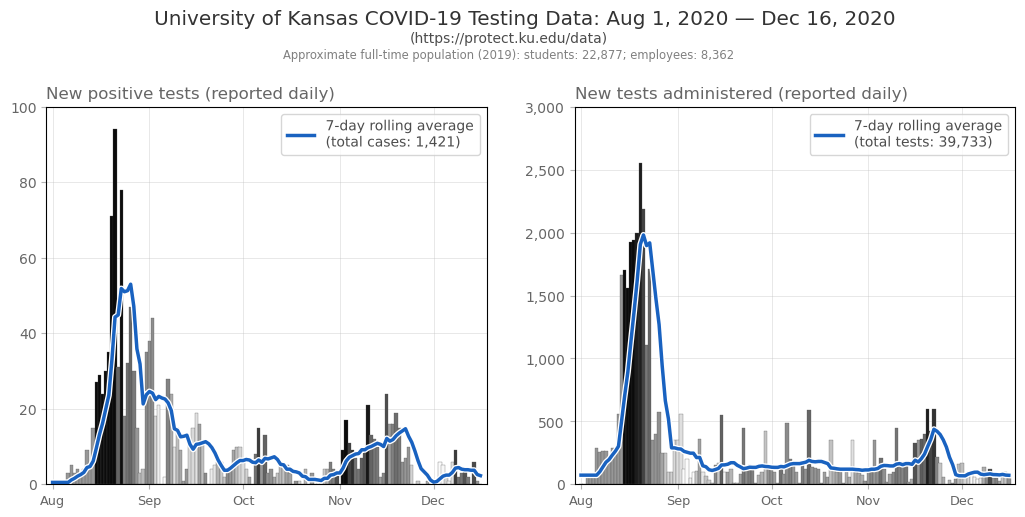

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of Kansas,https://protect.ku.edu/data,155317,29,Kansas,20045,1421,39733
1,2020-08-02,0,0,University of Kansas,https://protect.ku.edu/data,155317,29,Kansas,20045,1421,39733
2,2020-08-03,50,0,University of Kansas,https://protect.ku.edu/data,155317,30,Kansas,20045,1421,39733
3,2020-08-04,50,0,University of Kansas,https://protect.ku.edu/data,155317,30,Kansas,20045,1421,39733
4,2020-08-05,50,0,University of Kansas,https://protect.ku.edu/data,155317,30,Kansas,20045,1421,39733


In [15]:
college_label = 'University of Kansas'
college_abbrv = 'KU'
college_color = '#0051ba'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

__________

# University of Illinois at Urbana-Champaign

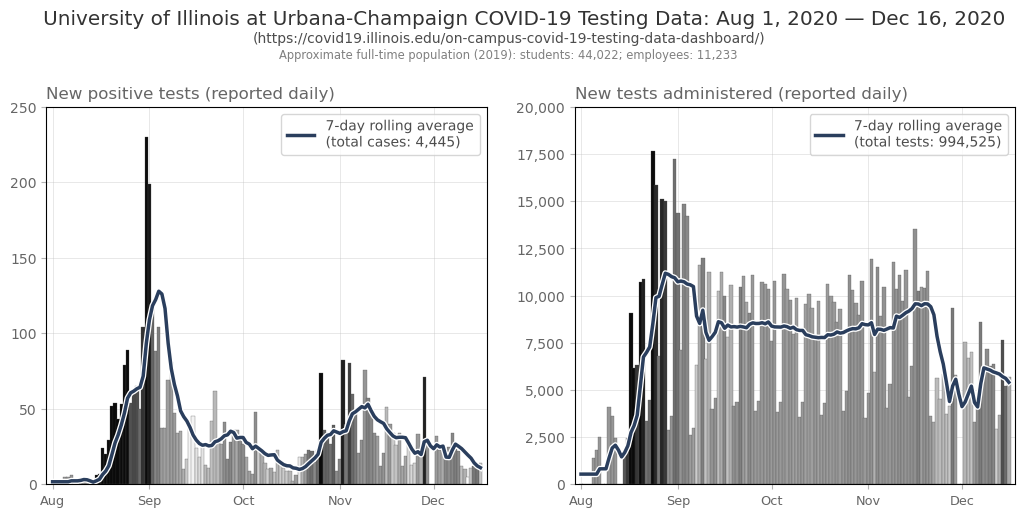

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of Illinois at Urbana-Champaign,https://covid19.illinois.edu/on-campus-covid-1...,145637,29,Illinois,17019,4445,994525
1,2020-08-02,0,0,University of Illinois at Urbana-Champaign,https://covid19.illinois.edu/on-campus-covid-1...,145637,29,Illinois,17019,4445,994525
2,2020-08-03,0,0,University of Illinois at Urbana-Champaign,https://covid19.illinois.edu/on-campus-covid-1...,145637,30,Illinois,17019,4445,994525
3,2020-08-04,0,0,University of Illinois at Urbana-Champaign,https://covid19.illinois.edu/on-campus-covid-1...,145637,30,Illinois,17019,4445,994525
4,2020-08-05,1405,5,University of Illinois at Urbana-Champaign,https://covid19.illinois.edu/on-campus-covid-1...,145637,30,Illinois,17019,4445,994525


In [16]:
college_label = 'University of Illinois at Urbana-Champaign'
college_abbrv = 'UIUC'
college_color = '#13294B'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_________

# Purdue University-Main Campus

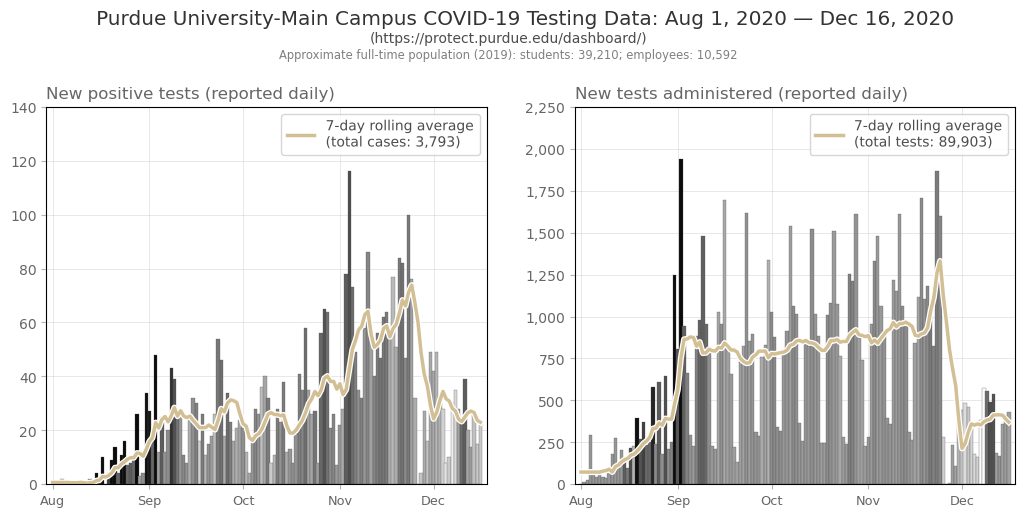

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,2,0,Purdue University-Main Campus,https://protect.purdue.edu/dashboard/,243780,30,Indiana,18157,3793,89903
1,2020-08-02,16,0,Purdue University-Main Campus,https://protect.purdue.edu/dashboard/,243780,30,Indiana,18157,3793,89903
2,2020-08-03,27,0,Purdue University-Main Campus,https://protect.purdue.edu/dashboard/,243780,30,Indiana,18157,3793,89903
3,2020-08-04,292,2,Purdue University-Main Campus,https://protect.purdue.edu/dashboard/,243780,30,Indiana,18157,3793,89903
4,2020-08-05,55,1,Purdue University-Main Campus,https://protect.purdue.edu/dashboard/,243780,31,Indiana,18157,3793,89903


In [17]:
college_label = 'Purdue University-Main Campus'
college_abbrv = 'Purdue'
college_color = '#CEB888'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

__________

# West Virginia University Institute of Technology

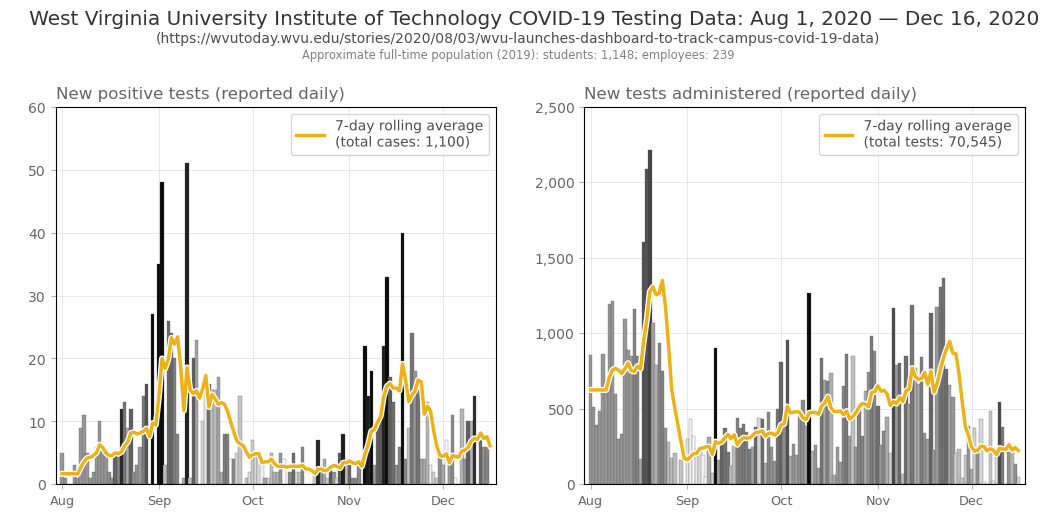

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,857,5,West Virginia University Institute of Technology,https://wvutoday.wvu.edu/stories/2020/08/03/wv...,237950,30,West Virginia,54081,1100,70545
1,2020-08-02,514,1,West Virginia University Institute of Technology,https://wvutoday.wvu.edu/stories/2020/08/03/wv...,237950,30,West Virginia,54081,1100,70545
2,2020-08-03,391,0,West Virginia University Institute of Technology,https://wvutoday.wvu.edu/stories/2020/08/03/wv...,237950,30,West Virginia,54081,1100,70545
3,2020-08-04,482,0,West Virginia University Institute of Technology,https://wvutoday.wvu.edu/stories/2020/08/03/wv...,237950,30,West Virginia,54081,1100,70545
4,2020-08-05,866,3,West Virginia University Institute of Technology,https://wvutoday.wvu.edu/stories/2020/08/03/wv...,237950,31,West Virginia,54081,1100,70545


In [18]:
college_label = 'West Virginia University Institute of Technology'
college_abbrv = 'WVU Tech'
college_color = '#eaaa00'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_________

# Tulane University of Louisiana

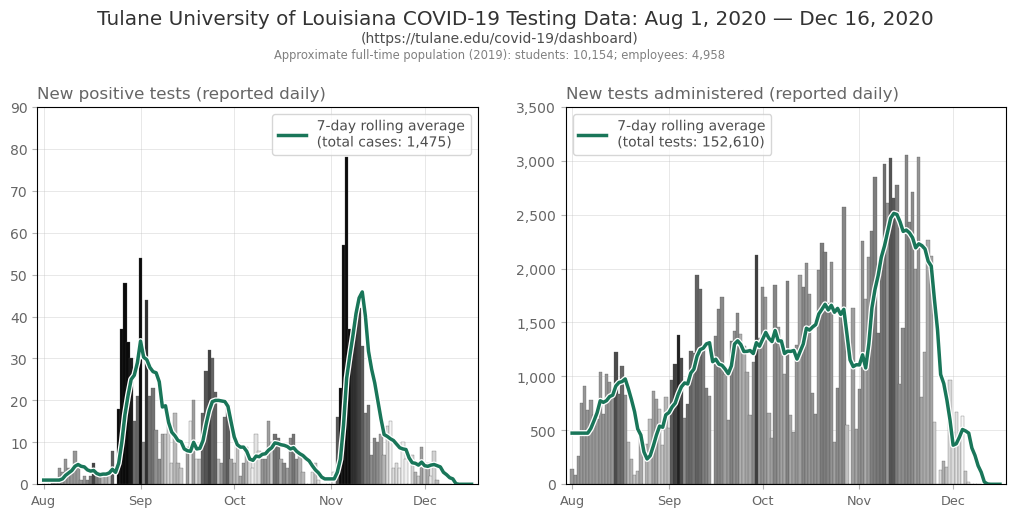

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,145,0,Tulane University of Louisiana,https://tulane.edu/covid-19/dashboard,160755,29,Louisiana,22071,1475,152610
1,2020-08-02,86,0,Tulane University of Louisiana,https://tulane.edu/covid-19/dashboard,160755,29,Louisiana,22071,1475,152610
2,2020-08-03,259,0,Tulane University of Louisiana,https://tulane.edu/covid-19/dashboard,160755,30,Louisiana,22071,1475,152610
3,2020-08-04,758,1,Tulane University of Louisiana,https://tulane.edu/covid-19/dashboard,160755,30,Louisiana,22071,1475,152610
4,2020-08-05,911,1,Tulane University of Louisiana,https://tulane.edu/covid-19/dashboard,160755,30,Louisiana,22071,1475,152610


In [19]:
college_label = 'Tulane University of Louisiana'
college_abbrv = 'Tulane'
college_color = '#006747'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

__________________

# Cornell University

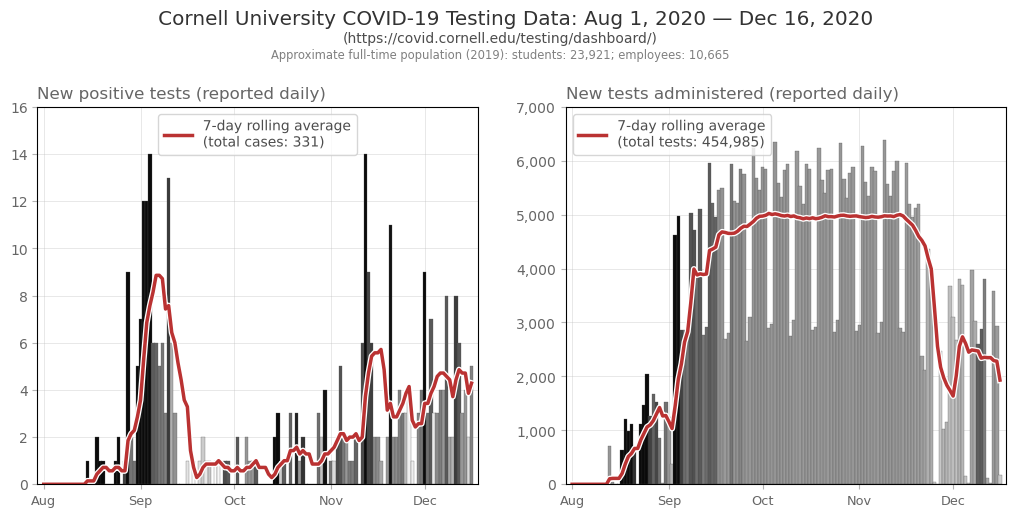

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Cornell University,https://covid.cornell.edu/testing/dashboard/,190415,29,New York,36109,331,454985
1,2020-08-02,0,0,Cornell University,https://covid.cornell.edu/testing/dashboard/,190415,29,New York,36109,331,454985
2,2020-08-03,0,0,Cornell University,https://covid.cornell.edu/testing/dashboard/,190415,30,New York,36109,331,454985
3,2020-08-04,0,0,Cornell University,https://covid.cornell.edu/testing/dashboard/,190415,30,New York,36109,331,454985
4,2020-08-05,0,0,Cornell University,https://covid.cornell.edu/testing/dashboard/,190415,30,New York,36109,331,454985


In [20]:
college_label = 'Cornell University'
college_abbrv = 'Cornell'
college_color = '#B31B1B'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

____________

# University of Nebraska-Lincoln

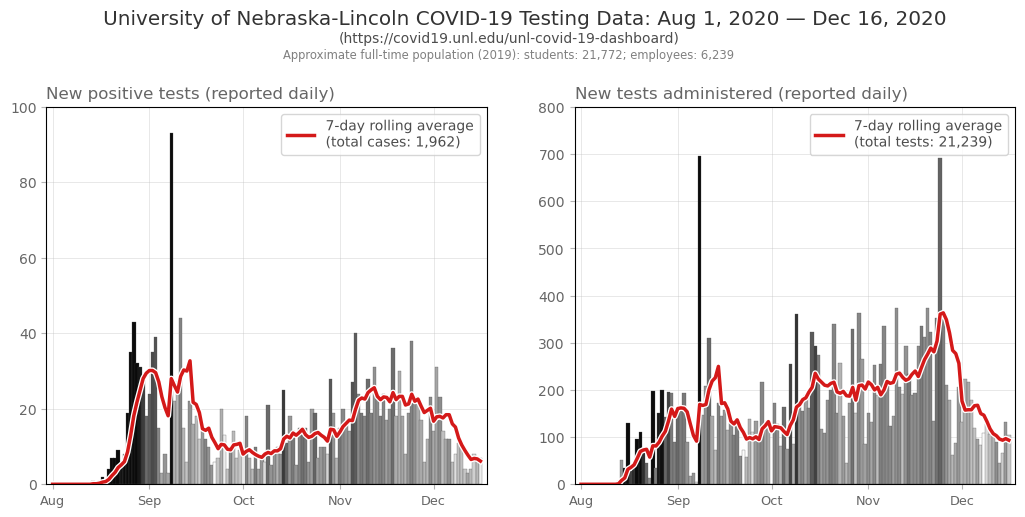

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of Nebraska-Lincoln,https://covid19.unl.edu/unl-covid-19-dashboard,181464,29,Nebraska,31109,1962,21239
1,2020-08-02,0,0,University of Nebraska-Lincoln,https://covid19.unl.edu/unl-covid-19-dashboard,181464,29,Nebraska,31109,1962,21239
2,2020-08-03,0,0,University of Nebraska-Lincoln,https://covid19.unl.edu/unl-covid-19-dashboard,181464,30,Nebraska,31109,1962,21239
3,2020-08-04,0,0,University of Nebraska-Lincoln,https://covid19.unl.edu/unl-covid-19-dashboard,181464,30,Nebraska,31109,1962,21239
4,2020-08-05,0,0,University of Nebraska-Lincoln,https://covid19.unl.edu/unl-covid-19-dashboard,181464,30,Nebraska,31109,1962,21239


In [21]:
college_label = 'University of Nebraska-Lincoln'
college_abbrv = 'UNL'
college_color = '#d00000'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

___________

# Swarthmore College

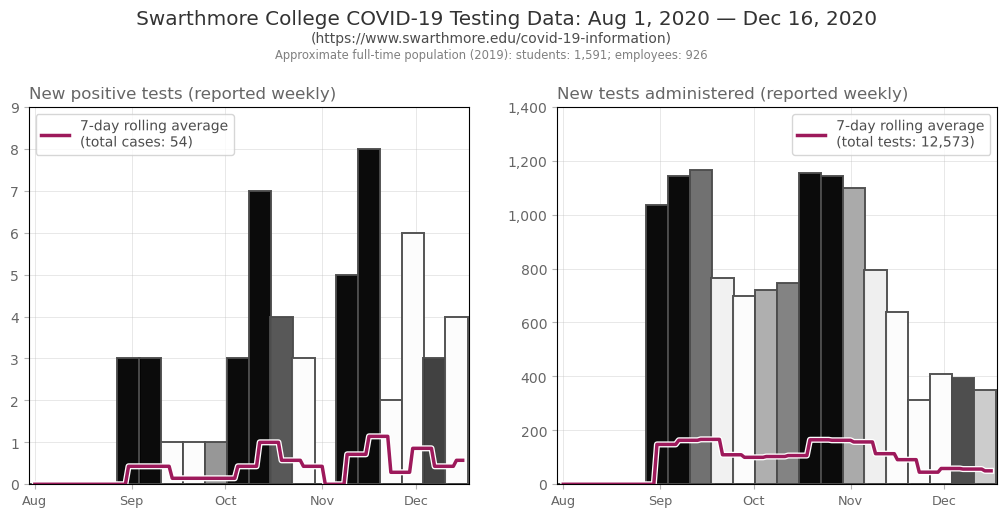

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Swarthmore College,https://www.swarthmore.edu/covid-19-information,216287,29,Pennsylvania,42045,54,12573
1,2020-08-02,0,0,Swarthmore College,https://www.swarthmore.edu/covid-19-information,216287,29,Pennsylvania,42045,54,12573
2,2020-08-03,0,0,Swarthmore College,https://www.swarthmore.edu/covid-19-information,216287,30,Pennsylvania,42045,54,12573
3,2020-08-04,0,0,Swarthmore College,https://www.swarthmore.edu/covid-19-information,216287,30,Pennsylvania,42045,54,12573
4,2020-08-05,0,0,Swarthmore College,https://www.swarthmore.edu/covid-19-information,216287,30,Pennsylvania,42045,54,12573


In [22]:
college_label = 'Swarthmore College'
college_abbrv = 'Swarthmore'
college_color = '#930049'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_____________

# University of Miami

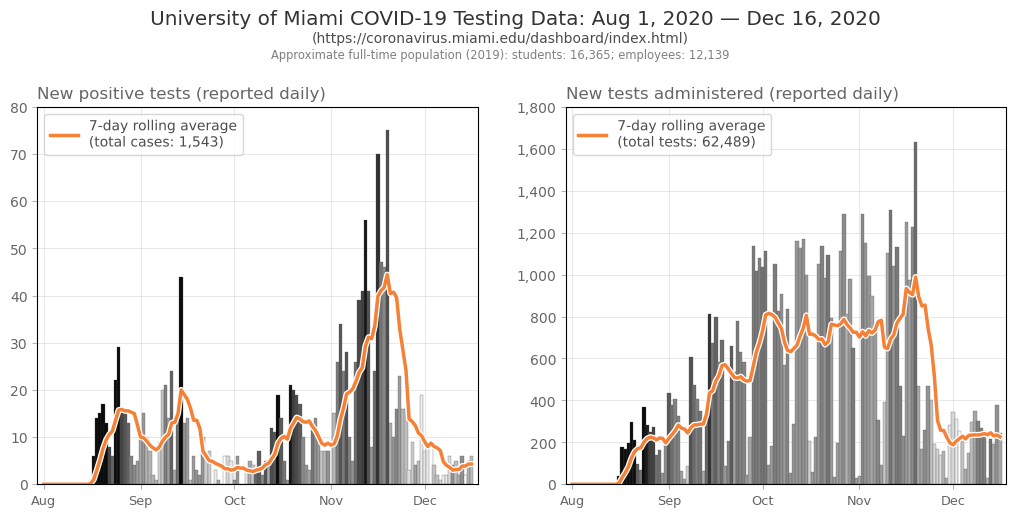

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of Miami,https://coronavirus.miami.edu/dashboard/index....,135726,29,Florida,12086,1543,62489
1,2020-08-02,0,0,University of Miami,https://coronavirus.miami.edu/dashboard/index....,135726,29,Florida,12086,1543,62489
2,2020-08-03,0,0,University of Miami,https://coronavirus.miami.edu/dashboard/index....,135726,30,Florida,12086,1543,62489
3,2020-08-04,0,0,University of Miami,https://coronavirus.miami.edu/dashboard/index....,135726,30,Florida,12086,1543,62489
4,2020-08-05,0,0,University of Miami,https://coronavirus.miami.edu/dashboard/index....,135726,30,Florida,12086,1543,62489


In [23]:
college_label = 'University of Miami'
college_abbrv = 'Miami'
college_color = '#f47321'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_________________

# University of Wisconsin-Madison

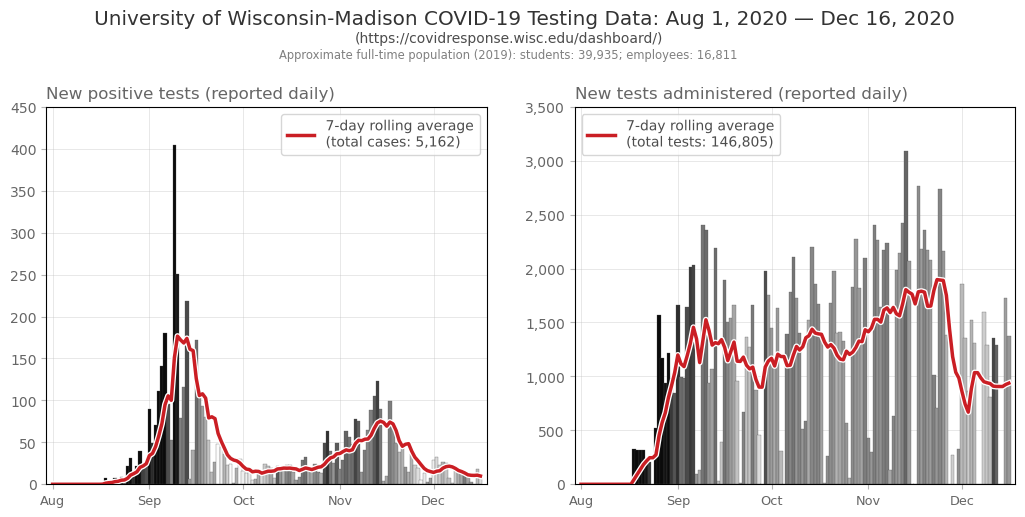

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of Wisconsin-Madison,https://covidresponse.wisc.edu/dashboard/,240444,29,Wisconsin,55025,5162,146805
1,2020-08-02,0,0,University of Wisconsin-Madison,https://covidresponse.wisc.edu/dashboard/,240444,29,Wisconsin,55025,5162,146805
2,2020-08-03,0,0,University of Wisconsin-Madison,https://covidresponse.wisc.edu/dashboard/,240444,30,Wisconsin,55025,5162,146805
3,2020-08-04,0,0,University of Wisconsin-Madison,https://covidresponse.wisc.edu/dashboard/,240444,30,Wisconsin,55025,5162,146805
4,2020-08-05,0,0,University of Wisconsin-Madison,https://covidresponse.wisc.edu/dashboard/,240444,30,Wisconsin,55025,5162,146805


In [24]:
college_label = 'University of Wisconsin-Madison'
college_abbrv = 'UW'
college_color = '#C5050C'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

__________

# Ohio State University-Main Campus

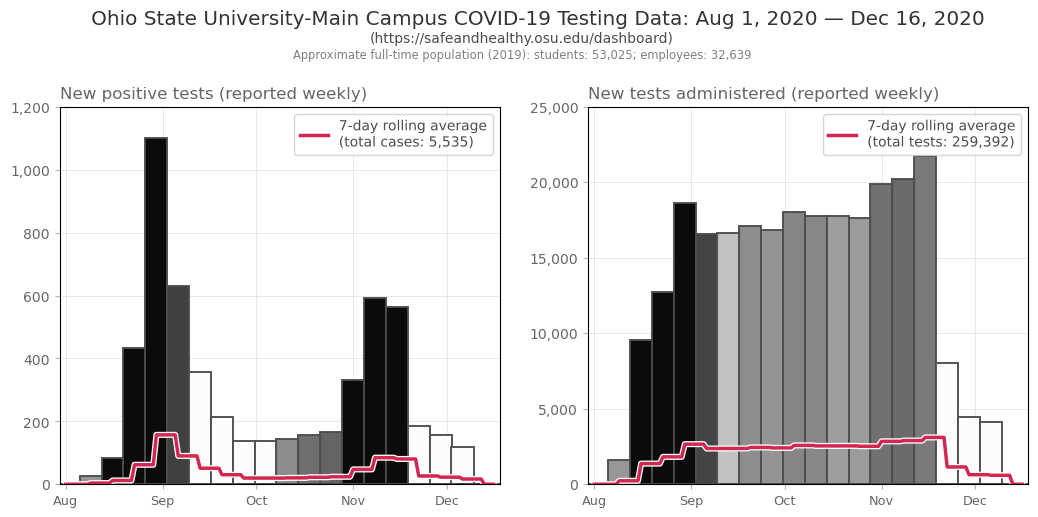

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Ohio State University-Main Campus,https://safeandhealthy.osu.edu/dashboard,204796,29,Ohio,39049,5535,259392
1,2020-08-02,0,0,Ohio State University-Main Campus,https://safeandhealthy.osu.edu/dashboard,204796,29,Ohio,39049,5535,259392
2,2020-08-03,0,0,Ohio State University-Main Campus,https://safeandhealthy.osu.edu/dashboard,204796,30,Ohio,39049,5535,259392
3,2020-08-04,0,0,Ohio State University-Main Campus,https://safeandhealthy.osu.edu/dashboard,204796,30,Ohio,39049,5535,259392
4,2020-08-05,0,0,Ohio State University-Main Campus,https://safeandhealthy.osu.edu/dashboard,204796,30,Ohio,39049,5535,259392


In [25]:
college_label = 'Ohio State University-Main Campus'
college_abbrv = 'Ohio State'
college_color = '#CE0F3D'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_________________

# Clemson University

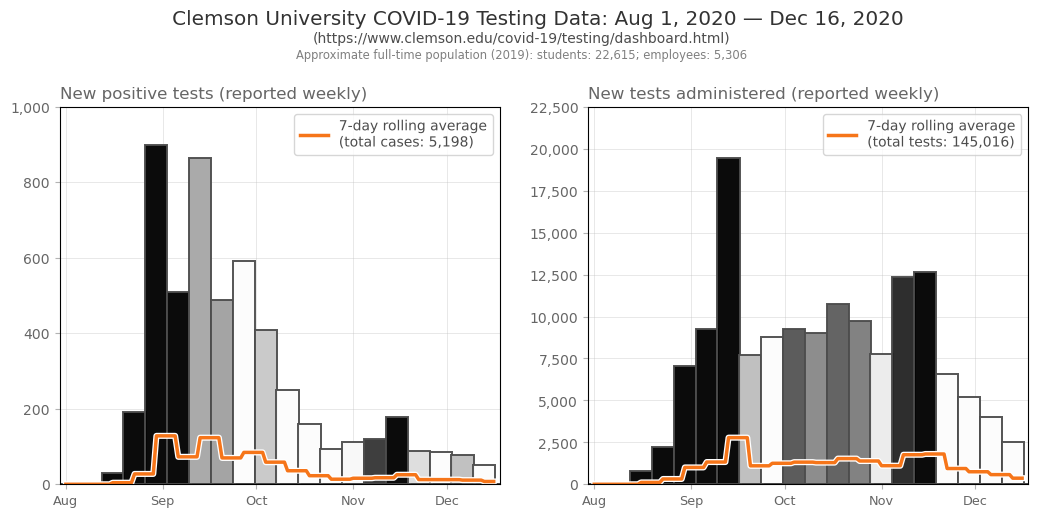

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Clemson University,https://www.clemson.edu/covid-19/testing/dashb...,217882,29,South Carolina,45077,5198,145016
1,2020-08-02,0,0,Clemson University,https://www.clemson.edu/covid-19/testing/dashb...,217882,29,South Carolina,45077,5198,145016
2,2020-08-03,0,0,Clemson University,https://www.clemson.edu/covid-19/testing/dashb...,217882,30,South Carolina,45077,5198,145016
3,2020-08-04,0,0,Clemson University,https://www.clemson.edu/covid-19/testing/dashb...,217882,30,South Carolina,45077,5198,145016
4,2020-08-05,0,0,Clemson University,https://www.clemson.edu/covid-19/testing/dashb...,217882,30,South Carolina,45077,5198,145016


In [26]:
college_label = 'Clemson University'
college_abbrv = 'Clemson'
college_color = '#F56600'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_____________

# Western Michigan University

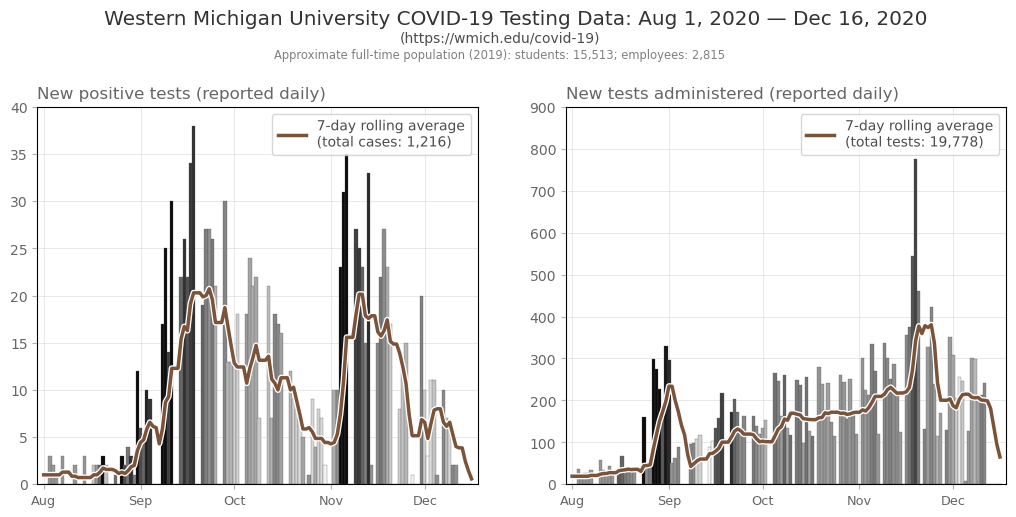

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Western Michigan University,https://wmich.edu/covid-19,172699,29,Michigan,26077,1216,19778
1,2020-08-02,1,0,Western Michigan University,https://wmich.edu/covid-19,172699,29,Michigan,26077,1216,19778
2,2020-08-03,37,3,Western Michigan University,https://wmich.edu/covid-19,172699,30,Michigan,26077,1216,19778
3,2020-08-04,23,2,Western Michigan University,https://wmich.edu/covid-19,172699,30,Michigan,26077,1216,19778
4,2020-08-05,26,1,Western Michigan University,https://wmich.edu/covid-19,172699,30,Michigan,26077,1216,19778


In [27]:
college_label = 'Western Michigan University'
college_abbrv = 'WMU'
college_color = '#6C4023'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_____________

# Rhode Island School of Design

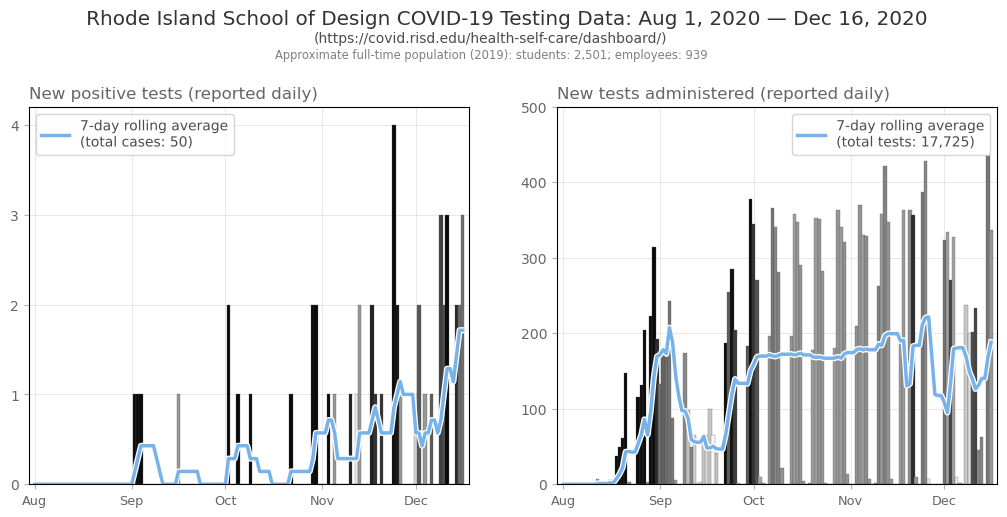

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Rhode Island School of Design,https://covid.risd.edu/health-self-care/dashbo...,217493,29,Rhode Island,44007,50,17725
1,2020-08-02,0,0,Rhode Island School of Design,https://covid.risd.edu/health-self-care/dashbo...,217493,29,Rhode Island,44007,50,17725
2,2020-08-03,0,0,Rhode Island School of Design,https://covid.risd.edu/health-self-care/dashbo...,217493,30,Rhode Island,44007,50,17725
3,2020-08-04,0,0,Rhode Island School of Design,https://covid.risd.edu/health-self-care/dashbo...,217493,30,Rhode Island,44007,50,17725
4,2020-08-05,0,0,Rhode Island School of Design,https://covid.risd.edu/health-self-care/dashbo...,217493,30,Rhode Island,44007,50,17725


In [28]:
college_label = 'Rhode Island School of Design'
college_abbrv = 'RISD'
college_color = '#68ABE8'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_________________

# New York University

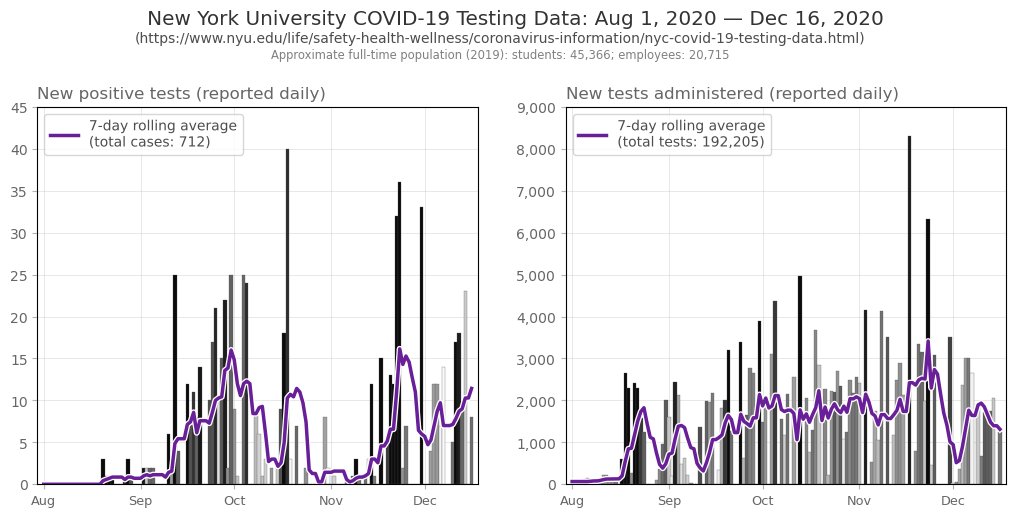

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,New York University,https://www.nyu.edu/life/safety-health-wellnes...,193900,29,New York,36061,712,192205
1,2020-08-02,0,0,New York University,https://www.nyu.edu/life/safety-health-wellnes...,193900,29,New York,36061,712,192205
2,2020-08-03,16,0,New York University,https://www.nyu.edu/life/safety-health-wellnes...,193900,30,New York,36061,712,192205
3,2020-08-04,93,0,New York University,https://www.nyu.edu/life/safety-health-wellnes...,193900,30,New York,36061,712,192205
4,2020-08-05,129,0,New York University,https://www.nyu.edu/life/safety-health-wellnes...,193900,30,New York,36061,712,192205


In [29]:
college_label = 'New York University'
college_abbrv = 'NYU'
college_color = '#57068C'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_______________

# University of North Georgia

"UNG Student Health Services does not currently have access to rapid testing, and would need to partner with Northeast Georgia Health System or the GDPH District 2 and District 10 offices to administer tests" (https://ung.edu/together/_uploads/files/ung-fall-2020-return-to-campus-plan.pdf page 115)

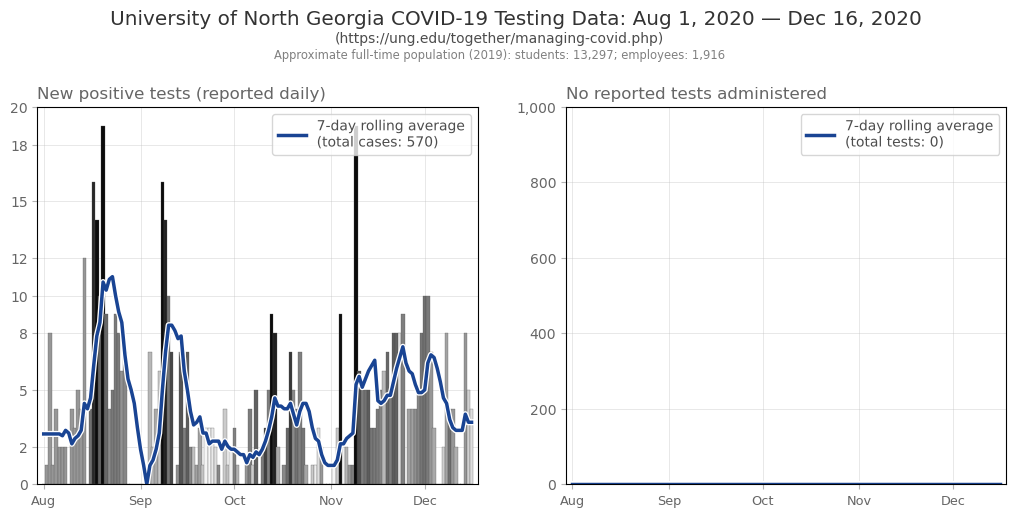

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,University of North Georgia,https://ung.edu/together/managing-covid.php,482680,29,Georgia,13187,570,0
1,2020-08-02,0,1,University of North Georgia,https://ung.edu/together/managing-covid.php,482680,29,Georgia,13187,570,0
2,2020-08-03,0,8,University of North Georgia,https://ung.edu/together/managing-covid.php,482680,30,Georgia,13187,570,0
3,2020-08-04,0,1,University of North Georgia,https://ung.edu/together/managing-covid.php,482680,30,Georgia,13187,570,0
4,2020-08-05,0,4,University of North Georgia,https://ung.edu/together/managing-covid.php,482680,30,Georgia,13187,570,0


In [30]:
college_label = 'University of North Georgia'
college_abbrv = 'UNG'
college_color = '#002f87'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

# Amherst College

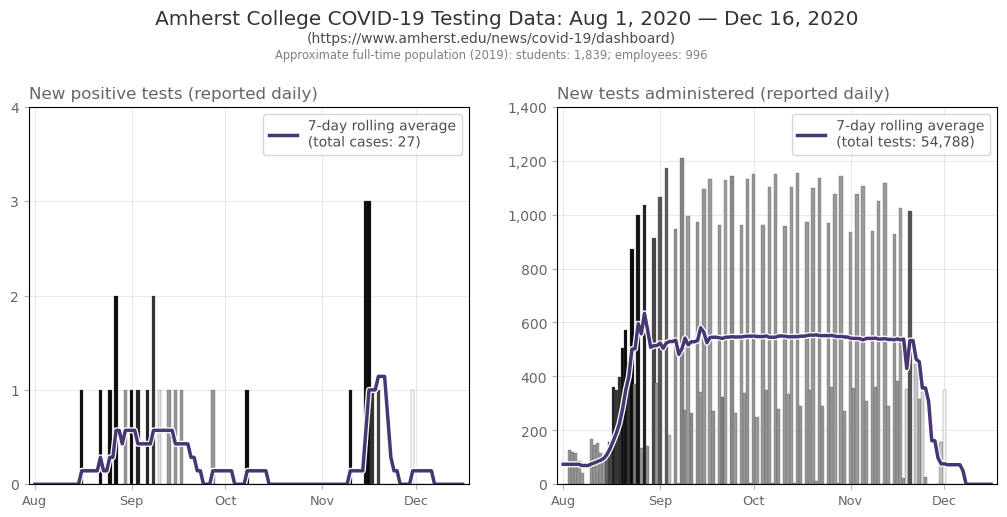

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Amherst College,https://www.amherst.edu/news/covid-19/dashboard,164465,29,Massachusetts,25015,27,54788
1,2020-08-02,0,0,Amherst College,https://www.amherst.edu/news/covid-19/dashboard,164465,29,Massachusetts,25015,27,54788
2,2020-08-03,127,0,Amherst College,https://www.amherst.edu/news/covid-19/dashboard,164465,30,Massachusetts,25015,27,54788
3,2020-08-04,118,0,Amherst College,https://www.amherst.edu/news/covid-19/dashboard,164465,30,Massachusetts,25015,27,54788
4,2020-08-05,115,0,Amherst College,https://www.amherst.edu/news/covid-19/dashboard,164465,30,Massachusetts,25015,27,54788


In [31]:
college_label = 'Amherst College'
college_abbrv = 'Amherst'
college_color = '#332064'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

____________

# Union College

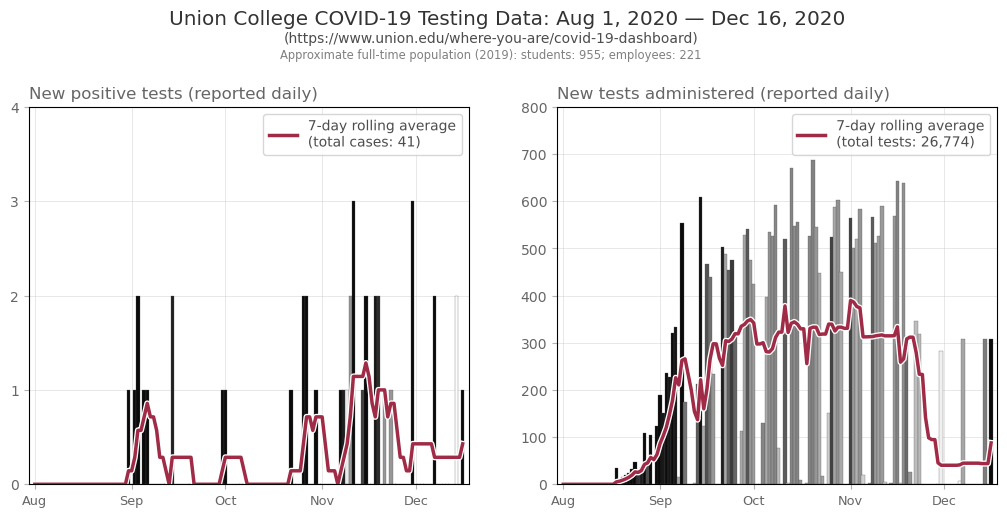

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,0,0,Union College,https://www.union.edu/where-you-are/covid-19-d...,196866,29,New York,36093,41,26774
1,2020-08-02,0,0,Union College,https://www.union.edu/where-you-are/covid-19-d...,196866,29,New York,36093,41,26774
2,2020-08-03,0,0,Union College,https://www.union.edu/where-you-are/covid-19-d...,196866,30,New York,36093,41,26774
3,2020-08-04,0,0,Union College,https://www.union.edu/where-you-are/covid-19-d...,196866,30,New York,36093,41,26774
4,2020-08-05,0,0,Union College,https://www.union.edu/where-you-are/covid-19-d...,196866,30,New York,36093,41,26774


In [32]:
college_label = 'Union College'
college_abbrv = 'Union College'
college_color = '#951432'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['state']=='New York')&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

__________

# University of Notre Dame

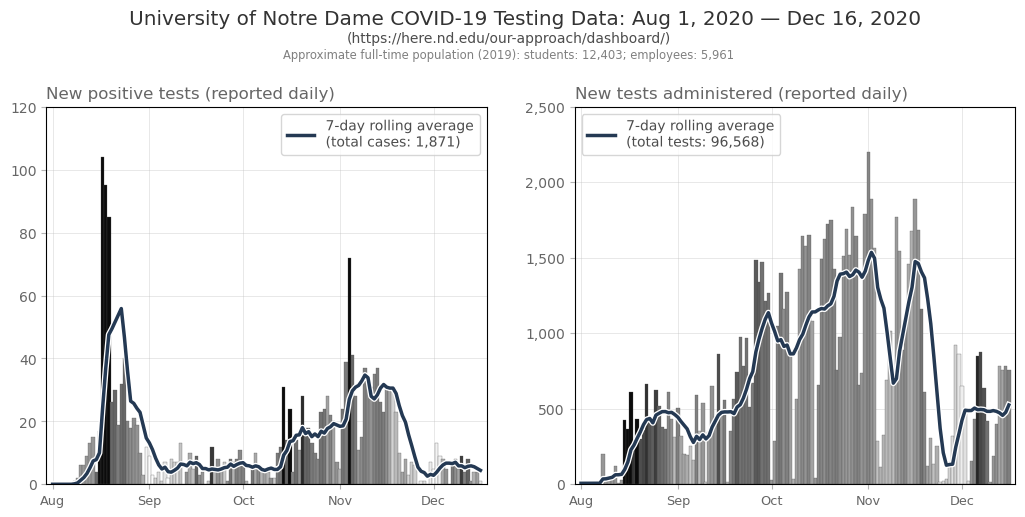

,date,total_tests,positive_tests,college,url,ipeds_id,week,state,fips,cumulative_cases,cumulative_tests
0,2020-08-01,3,0,University of Notre Dame,https://here.nd.edu/our-approach/dashboard/,152080,30,Indiana,18141,1871,96568
1,2020-08-02,10,0,University of Notre Dame,https://here.nd.edu/our-approach/dashboard/,152080,30,Indiana,18141,1871,96568
2,2020-08-03,7,0,University of Notre Dame,https://here.nd.edu/our-approach/dashboard/,152080,30,Indiana,18141,1871,96568
3,2020-08-04,6,0,University of Notre Dame,https://here.nd.edu/our-approach/dashboard/,152080,30,Indiana,18141,1871,96568
4,2020-08-05,3,0,University of Notre Dame,https://here.nd.edu/our-approach/dashboard/,152080,31,Indiana,18141,1871,96568


In [33]:
college_label = 'University of Notre Dame'
college_abbrv = 'Notre Dame'
college_color = '#0C2340'

data_u = ihe_df.loc[(ihe_df['college']==college_label)&\
                    (ihe_df['date']>=data_date)].copy().reset_index().iloc[:,1:]

plot_school(data_u, college_label, college_abbrv, college_color)
data_u.head()

_____________

In [34]:
# tmp = ihe_df.loc[(ihe_df['total_tests']==0)&\
#                  (ihe_df['positive_tests']==0)].copy()
# tmp = tmp.groupby(['college','ipeds_id']).agg({'date':'count','cumulative_cases':'max',
#            'cumulative_tests':'max'}).reset_index().sort_values('date').reset_index().iloc[:,1:]
# tmp = tmp.rename(columns={'date':'lor'})
# tmp['lor'] = 138-tmp['lor']

# ihe_dfg = ihe_df[['ipeds_id','state','college','cumulative_tests','cumulative_cases']].drop_duplicates()
# ihe_dfg = ihe_dfg.merge(ipeds_df[['ipeds_id','enrollment_fulltime']], how='left',on='ipeds_id')
# ihe_dfg = ihe_dfg.loc[ihe_dfg['enrollment_fulltime']>0].dropna()
# ihe_dfg['avg_tests_ppw'] = (ihe_dfg['cumulative_tests'] /\
#                                 ihe_dfg['enrollment_fulltime'] /\
#                                     ihe_df['week'].nunique()).round(3)
# ihe_dfg = ihe_dfg.sort_values('avg_tests_ppw',ascending=False).reset_index().iloc[:,1:]
# ihe_dfg = ihe_dfg.merge(tmp[['ipeds_id','lor']], how='left', on='ipeds_id')

# ihe_dfg.iloc[:50,:]